### LANDLAB X SHRED Sandbox Description
This notebook experiments with the usage of sensor placement, sparsity, lags, and various other variables within the SHRED system to see how developers can optimize their usage of SHRED for forecasting and reconstruction of various spatiotemporal datasets. In this example, we will use our own spatiotemporal dataset of elevation uplift to see if SHRED can capture the evolution of the landscape.

In [126]:
# Import all dependencies
import pyshred
from pyshred import *
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Including Landlab dependencies
from landlab.plot import imshow_grid
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, FastscapeEroder, LinearDiffuser, PerronNLDiffuse, TaylorNonLinearDiffuser
from matplotlib.pyplot import figure, show, plot, xlabel, ylabel, title

data = []
# data stores an entire elevation map for every index, where indices are timesteps in years

[0.14459007 0.10087615 0.01163631 ... 0.00188988 0.0741109  0.18794495]
[100. 100. 100. ... 100. 100. 100.]


c:\myapps\Anaconda\envs\shred-ll-env\lib\site-packages\landlab\field\graph_field.py:1347: FutureWarning: Calling `add_empty` with the field location as the first argument is deprecated and will be removed in future versions. Instead, please use the `at` keyword to specify the location: add_empty(arg0, at='node').
  data = self.add_empty(*args, **kwds)


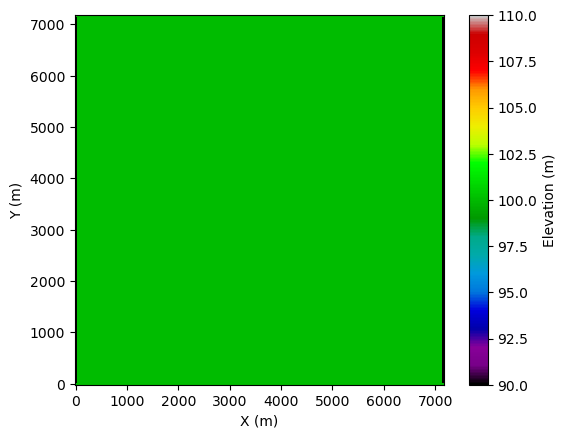

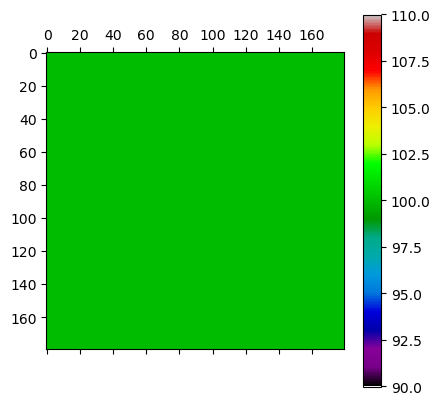

In [127]:
# The grid is 200 rows by 150 columns, with dx = dy = 50 m.
cell_width_length=40
rows=180
columns=180

mg = RasterModelGrid((rows, columns), cell_width_length) 

mg.set_closed_boundaries_at_grid_edges(
    right_is_closed=True,
    top_is_closed=False,
    left_is_closed=True,
    bottom_is_closed=False
)

# Create an initial elevation field with some random perturbations.
# Elevation will be, by default 100 m not 0.
z = 100 + mg.add_zeros('node', 'topographic__elevation')

# Add roughness
initial_roughness = np.random.rand(mg.core_nodes.size) / 5

# Add roughness to the elevation field
mg.at_node['topographic__elevation'][mg.core_nodes] += initial_roughness

# Print the elevation field, 1D
print(mg.at_node['topographic__elevation'][mg.core_nodes])
print(z)

# Reshape to a 2D matshow-able array
z_2d = np.reshape(z, (rows, columns))


# Plot the elevation field.
imshow_grid(mg, z, grid_units=['m','m'], var_name='Elevation (m)', cmap='nipy_spectral')  
plt.matshow(z_2d, cmap='nipy_spectral')
plt.colorbar()

# So z_2d stores a 180 x 180 array of our true elevation field, z.

Now let's make the spatiotemporal dataset: applying uplift to the elevation field over time and allowing the deltas to form, then stacking those full states into a vector of full states.

In [128]:
# total_t = 5000000. # this is how long we will run the model for
total_t = 5000000
dt = 1000 # time step in years over which cumulative erosion is calculated and applied to each cell to speed up the model we can use long time scales when hydrology is steady-state in a year. t
nt = int(total_t // dt) # number of time steps


# used for SHRED later, we set a "lags", trying to capture a reasonable time window where
# change occurs -> not too small so that no change is captured, not so large that nothing is
# captured.
reasonable_lag = 20

uplift_rate = 0.0004 # uplift rate, this can be a lot hire when landslides are considered
uplift_per_step = uplift_rate * dt # depth (m) of uplift per timestep

Mean_elev=[] # an array to hold the mean elevation of the modeled domain

### Instantiate the process components for this model
In this case the difference components are:
  * `FlowAccumulator` which determines the drainage area at each point. In this case we are using `D8` to determine downslope neighbors.
  * `FastscapeEroder` which calculates the incision rate based on a power-law function of discharge and slope. This uses the Braun and Willet algorithm, reference <a href="http://www.sciencedirect.com/science/article/pii/S0169555X12004618">here</a>)
  * `Diffusers` which calculates erosion and deposition of material using a sediment transport rate which is proportional to the slope. 
  * Note that in the case of `FastscapeEroder`, the values are noted when the class is instantiated. In the case of the `LinearDiffuser`, the value is assigned to a variable and that variable is sent to the class. There are multiple ways to do things, depending on your coding style and what makes sense to you.
  * Remember that the grid was made with an assumed dx in meters. Time values are in years. So any parameters should have units of meters and years.

In [129]:
# Choose diffusivity value and instantiate objects for hillslope diffusion and assign parameter values

# Option 1: LinearDiffuser
k_d = 0.01  # m2/y this is a high-end for this parameter
lin_diffuse = LinearDiffuser(mg, linear_diffusivity=k_d, deposit=True)

# Option 2: Non-linear Diffusion
k_d_nonlin=0.01    # 0.01-0.03   for Oregon like forest, first number with fires second w/o
Sc=1.125           # 1-1.25      for Oregon like forest, first number with fires second w/o
Taylor_nonlin_diffuse = TaylorNonLinearDiffuser(mg, linear_diffusivity=k_d_nonlin, slope_crit=Sc, if_unstable='warn')

# NOTE that if deposit=True, the slope area data will look different.

In [130]:
# Instantiate an object of the FlowAccumulator
fr = FlowAccumulator(mg, flow_director='FlowDirectorD8') 

# Choose parameter values for the stream power (SP) equation
# and instantiate an object of the FastscapeEroder
K_sp=0.00001 # erodibility in SP eqtn, units depend on m_sp (0.00001 for m=0.5) (0.00005 for m=0.25)
m_sp=0.5 # exponent on drainage area in SP eqtn
n_sp=1 # exponent on slope in the SP eqtn

sp = FastscapeEroder(mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0)

### Initialize sensor measurement data collection variables
An easy way to store sensor measurements is to organize sensor readings by rows (representing different sensors or locations) and columns (representing times).

In [131]:
# Start with three sensors
land_sensors = 3
time_count = nt

temporal_elevation = np.zeros((land_sensors, time_count))

temporal_elevation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

* The calculations are all done in the time loop below.

In [132]:
elevation_snapshots = np.ndarray(shape=(nt, mg.at_node['topographic__elevation'][mg.core_nodes].shape[0]))
for i in range(nt):
    lin_diffuse.run_one_step(dt) # linear diffusion
    fr.run_one_step() # route flow
    sp.run_one_step(dt) # fluvial (SP) incision
    
    mg.at_node['topographic__elevation'][mg.core_nodes] += uplift_per_step # add the uplift
    Mean_elev.append(np.mean(mg.at_node['topographic__elevation'][mg.core_nodes]))
    elevation_snapshots[i] = mg.at_node['topographic__elevation'][mg.core_nodes]
    # Let's choose node 50, 100, and 150 for example
    temporal_elevation[0][i]=mg.at_node['topographic__elevation'][mg.core_nodes][100]
    temporal_elevation[1][i]=mg.at_node['topographic__elevation'][mg.core_nodes][300]
    temporal_elevation[2][i]=mg.at_node['topographic__elevation'][mg.core_nodes][400]
    
    if i % 500 == 0: 
      print ("Completed loop", i, "out of", nt)

# Now elevation_snapshots stores a full spatiotemporal dataset of our full states:
print(f"elevation_snapshots dims: {elevation_snapshots.shape}")

Completed loop 0 out of 5000
Completed loop 500 out of 5000
Completed loop 1000 out of 5000
Completed loop 1500 out of 5000
Completed loop 2000 out of 5000
Completed loop 2500 out of 5000
Completed loop 3000 out of 5000
Completed loop 3500 out of 5000
Completed loop 4000 out of 5000
Completed loop 4500 out of 5000
elevation_snapshots dims: (5000, 31684)


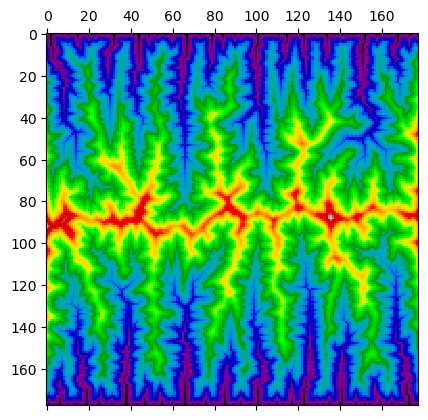

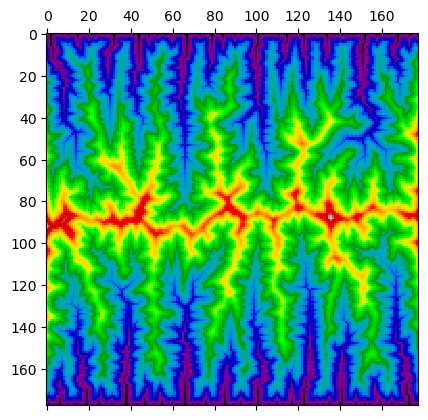

In [133]:
plt.matshow(np.reshape(elevation_snapshots[3000], (178, 178)), cmap="nipy_spectral")

data = np.ndarray(shape=(nt, 178, 178))
for i in range(elevation_snapshots.shape[0]):
    data[i] = np.reshape(elevation_snapshots[i], (178, 178))

plt.matshow(data[3000], cmap="nipy_spectral")


In [134]:
# This represents how much of our entire dataset we want to work with
start_year = 0 # default
end_year = int(input(f"Last year to include in data (size is {len(data)}): "))

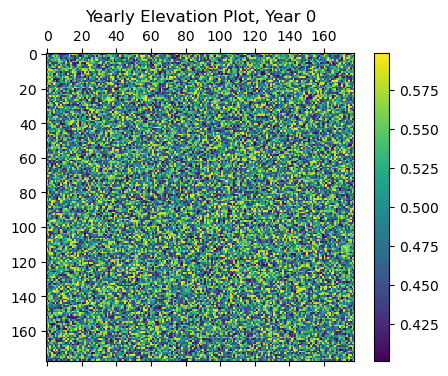

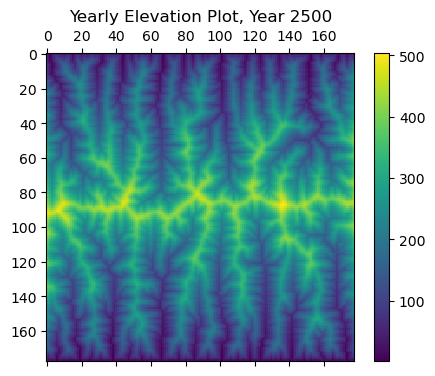

In [135]:
# Let's visualize the first and last year of data!
# Visually, this should give us an idea of what the trajectory of our data looks like
from re import A


fig, ax = plt.subplots(figsize=(5, 4))
im1 = ax.matshow(data[start_year])
ax.set_title(f"Yearly Elevation Plot, Year {start_year}")
plt.colorbar(im1, ax=ax)

fig, ax = plt.subplots(figsize=(5, 4))
im2 = ax.matshow(data[end_year])
ax.set_title(f"Yearly Elevation Plot, Year {end_year}")
plt.colorbar(im2, ax=ax)

Now let's set up our sensor locations: one "sparse" vector to store a few tuples of coordinates, and a "dense" vector to capture more coordinates.

In [136]:
# Used to compare performance of using different amounts of sensors
# in well placed locations.
sparse_locations = [(20, 40), (60, 60), (100, 100)]
dense_locations = [(20, 40), (60, 60), (100, 100), (160, 20), (20, 160), (50, 50), (40, 40), (30, 100)]

And let's define how much data to use to train our forecaster SHRED models to then compare to the rest of the ground truth

In [137]:
# Isolating half of the dataset to see if the SHRED forecast can predict beyond the test split of the whole dataset
# This will be used for both sparse and numerous sensor location tests
data_length = end_year // 2
isolated_data = data[:data_length]

Now let's initialize two DataManagers: to one we will only add the sparse datapoints, and to the other we will add the dense, more complete-picture datapoints.

In [138]:
# Define ratios
TRAIN_RATIO = 0.9
VAL_RATIO = 0.05
TEST_RATIO = 0.05

# Initialize sparse data manager
sparse_manager = DataManager(
    lags=reasonable_lag, # 52 years means short-term memory used to train SHRED model's LSTM will be a year long
    train_size=TRAIN_RATIO, 
    val_size=VAL_RATIO,
    test_size=TEST_RATIO,
)

sparse_manager.add_data(
    data=isolated_data,
    id="My_Sparse_SST",
    stationary=sparse_locations,
    compress=False
)

# Initialize dense data manager
dense_manager = DataManager(
    lags=reasonable_lag,
    train_size=TRAIN_RATIO,
    val_size=VAL_RATIO,
    test_size=TEST_RATIO,
)  

dense_manager.add_data(
    data=isolated_data,
    id="My_Dense_SST",
    stationary=dense_locations,
    compress=False
)

In [139]:
# Preview sparse and dense sensor measurements
sparse_manager.sensor_measurements_df

,My_Sparse_SST-0,My_Sparse_SST-1,My_Sparse_SST-2
0,0.493524,0.554859,0.405086
1,0.892545,0.951775,0.808037
2,1.291580,1.348820,1.210858
3,1.690632,1.745989,1.613556
4,2.089702,2.143277,2.016136
...,...,...,...
1245,84.829157,336.222466,278.930484
1246,84.814896,335.939337,278.633471
1247,84.800723,335.656430,278.338575
1248,84.786640,335.373752,278.045730


In [140]:
# Preview sparse and dense sensor measurements
dense_manager.sensor_measurements_df

,My_Dense_SST-0,My_Dense_SST-1,My_Dense_SST-2,My_Dense_SST-3,My_Dense_SST-4,My_Dense_SST-5,My_Dense_SST-6,My_Dense_SST-7
0,0.493524,0.554859,0.405086,0.412155,0.557553,0.575636,0.413086,0.430424
1,0.892545,0.951775,0.808037,0.814521,0.954003,0.972229,0.814488,0.831611
2,1.291580,1.348820,1.210858,1.216794,1.350603,1.368952,1.215843,1.232767
3,1.690632,1.745989,1.613556,1.618978,1.747349,1.765798,1.617153,1.633892
4,2.089702,2.143277,2.016136,2.021075,2.144233,2.162762,2.018421,2.034987
...,...,...,...,...,...,...,...,...
1245,84.829157,336.222466,278.930484,89.279322,246.946542,282.723203,227.580765,62.841037
1246,84.814896,335.939337,278.633471,89.254853,246.888067,282.615799,227.346882,62.826629
1247,84.800723,335.656430,278.338575,89.230545,246.829554,282.508460,227.116122,62.812351
1248,84.786640,335.373752,278.045730,89.206404,246.771007,282.401186,226.888396,62.798201


Now let's prepare two SHRED models: one using training/validation/testing data prepared by the sparse data manager, and the other using the one with more numerous sensors.

In [197]:
# Prepare sparse and dense train test val splits
sparse_train, sparse_val, sparse_test = sparse_manager.prepare()
dense_train, dense_val, dense_test = dense_manager.prepare()

# You can even define your own decoder and LSTM models here.
# Remember that the coupling is super flexible, so long as
# LSTM/temporal model outputs a final hidden state that can
# be used by the decoder model to output a full state space
sparse_shred = SHRED(
    sequence_model="LSTM",
    decoder_model="MLP",
    latent_forecaster="LSTM_Forecaster"
)

dense_shred = SHRED(
    sequence_model="LSTM",
    decoder_model="MLP",
    latent_forecaster="LSTM_Forecaster"
)

# Fit sparse and dense SHRED models, set epochs to 2 for brevity, increase if preferred
epoch_limit = 2

sparse_val_errors = sparse_shred.fit(
    train_dataset=sparse_train,
    val_dataset=sparse_val,
    num_epochs=epoch_limit,
    verbose=False
)

dense_val_errors = dense_shred.fit(
    train_dataset=dense_train,
    val_dataset=dense_val,
    num_epochs=epoch_limit,
    verbose=False
)

print(f"Sparse SHRED model's validation error: {sparse_val_errors}\nDense SHRED model's validation error: {dense_val_errors}\n")

Fitting SHRED...
Fitting SHRED...
Sparse SHRED model's validation error: [0.04672205 0.20887822]
Dense SHRED model's validation error: [0.02825735 0.10581727]



Evaluate the sparse and dense shred models

In [198]:
sparse_train_mse = sparse_shred.evaluate(dataset=sparse_train)
sparse_val_mse = sparse_shred.evaluate(dataset=sparse_val)
sparse_test_mse = sparse_shred.evaluate(dataset=sparse_test)

dense_train_mse = dense_shred.evaluate(dataset=dense_train)
dense_val_mse = dense_shred.evaluate(dataset=dense_val)
dense_test_mse = dense_shred.evaluate(dataset=dense_test)

print("Sparse Train MSE: ", sparse_train_mse)
print("Sparse Validation MSE: ", sparse_val_mse)
print("Sparse Test MSE: ", sparse_test_mse)

print("Dense Train MSE: ", dense_train_mse)
print("Dense Validation MSE: ", dense_val_mse)
print("Dense Test MSE: ", dense_test_mse)


Sparse Train MSE:  0.12383215634600009
Sparse Validation MSE:  0.20887821229092937
Sparse Test MSE:  0.20186093626947055
Dense Train MSE:  0.08087642422042671
Dense Validation MSE:  0.10581726466701419
Dense Test MSE:  0.10321292023363653


In order to run forecasting and reconstruction, we need to initialize sparse and dense SHRED engines that can turn our sensor measurement data into latents to train a sensor forecaster and turn forecasted and future sensor measurement tensors into full state reconstructions through SHRED's decoder.

In [199]:
sparse_engine = SHREDEngine(sparse_manager, sparse_shred)
dense_engine = SHREDEngine(dense_manager, dense_shred)

sparse_test_latents = sparse_engine.sensor_to_latent(sparse_manager.test_sensor_measurements)
sparse_val_latents = sparse_engine.sensor_to_latent(sparse_manager.val_sensor_measurements)

dense_test_latents = dense_engine.sensor_to_latent(dense_manager.test_sensor_measurements)
dense_val_latents = dense_engine.sensor_to_latent(dense_manager.val_sensor_measurements)

# Set up the forecaster and seed it with a bunch of the validation
# dataset's latent states.
sparse_init_latents = sparse_val_latents[-sparse_shred.latent_forecaster.seed_length:]
dense_init_latents = dense_val_latents[-dense_shred.latent_forecaster.seed_length:]

h = len(sparse_manager.test_sensor_measurements) # Testing the forecaster requires us to use h "future steps" where h is the length of the testing data, which is what we aim to predict with sensor forecaster initially.
h_2 = len(dense_manager.test_sensor_measurements)

# This is the big one: creating H steps of forecasted latents that are DIRECTLY
# COMPARABLE to the ground truth testing latents. In other words, we are first "predicting"
# what the test dataset's latents should be, then we can compare that to the actual
# testing dataset's latents.
test_latent_from_forecaster = sparse_engine.forecast_latent(h=h, init_latents=sparse_init_latents)
dense_latents_from_forecaster = dense_engine.forecast_latent(h=h_2, init_latents=dense_init_latents)

# So we can compare the differences in the latent states, techjnically, even before
# we reconstruct the full state from it by decoding.
mse = np.mean((test_latent_from_forecaster - sparse_test_latents)**2)
mse_2 = np.mean((dense_latents_from_forecaster - dense_test_latents)**2)
print("MSE of sparse test latents from forecasted latents: ", mse)
print("MSE of dense test latents from forecasted latents: ", mse_2)

MSE of sparse test latents from forecasted latents:  0.00010605807
MSE of dense test latents from forecasted latents:  0.0003563745


After running the MSE tests from above, it is more than likely that the dense test latents that are generated will be more accurate (lower MSE) than the MSE of sparse test latents. That's because the latents used to seed the sensor forecaster with the dense sensor data are more data-rich than the sparse sensor data, making the result closer to the real sensor data.

Now let's run reconstruction and forecasting.

Sparse MSE:  15.088711
Dense MSE:  375.31915


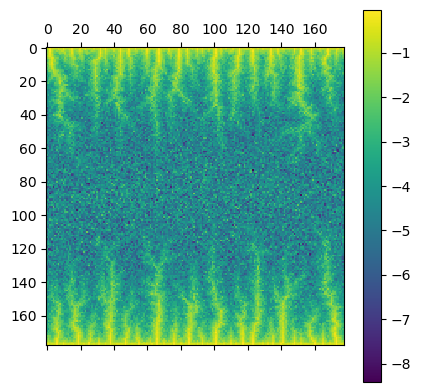

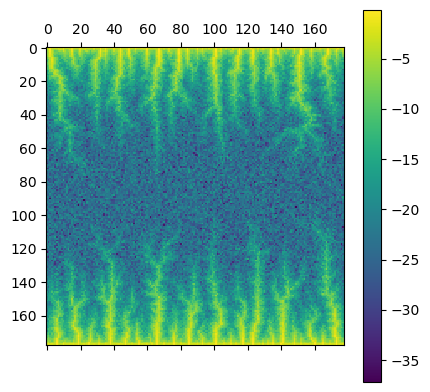

In [200]:
sparse_test_reconstruction = sparse_engine.decode(sparse_test_latents)
sparse_test_forecast = sparse_engine.decode(test_latent_from_forecaster)

dense_test_reconstruction = dense_engine.decode(dense_test_latents)
dense_test_forecast = dense_engine.decode(dense_latents_from_forecaster)

print("Sparse MSE: ", np.mean((sparse_test_reconstruction['My_Sparse_SST'][0] - sparse_test_forecast['My_Sparse_SST'][0])**2))
print("Dense MSE: ", np.mean((dense_test_reconstruction['My_Dense_SST'][0] - dense_test_forecast['My_Dense_SST'][0])**2))

plt.matshow(sparse_test_reconstruction['My_Sparse_SST'][0] - sparse_test_forecast['My_Sparse_SST'][0])
plt.colorbar()

plt.matshow(dense_test_reconstruction['My_Dense_SST'][0] - dense_test_forecast['My_Dense_SST'][0])
plt.colorbar()


In [145]:
# Now we're gonna use that futute forecaster to really see into the future,
# and see how accurate we are.

# First, get the latents from the future sensor measurements (after the isolated data)
# Then, use the decoder to decode those latents into full state spaces.
# Then, get hte MSE between those latents and the actual future sensor measurements.

future_manager_sparse = DataManager(
    lags=reasonable_lag,
    train_size=TRAIN_RATIO,
    val_size=VAL_RATIO,
    test_size=TEST_RATIO
)

future_manager_dense = DataManager(
    lags=reasonable_lag,
    train_size=TRAIN_RATIO,
    val_size=VAL_RATIO,
    test_size=TEST_RATIO
)

# dense_val_errors = dense_shred.fit(
#     train_dataset=dense_train,
#     val_dataset=dense_val,
#     num_epochs=epoch_limit,
#     verbose=False
# )

# Add our ground truth data, data that our previous
# SHRED models and sensor forecasters have never seen,
# and will be forced to predict.
future_manager_sparse.add_data(
    data=data,
    id="Sparse_Future_SST",
    stationary=sparse_locations,
)

future_manager_dense.add_data(
    data=data,
    id="Dense_Future_SST",
    stationary=dense_locations,
)

# Find where TESTING data begins:
testing_idx = int(len(data) - (len(data) * TEST_RATIO))
print(f"Data contains {len(data)} full states, testing states begin at idx {testing_idx}\n")
print(f"Full state at {testing_idx} used to be:\n{data[testing_idx]}\n")

# Uncomment this portion to simulate a REAL WORLD test case of not having
# full states beyond a certain point of time.
# And zero it out.
# This way we truly simulate the model having no visual of the full states 
# that it must forecast. In other words, we are simulating a real-world
# use case of SHRED forecasting.
for i in range(testing_idx, len(data)):
    data[i] = np.zeros((178,178))

print(f"Full state at {testing_idx} IS NOW:\n{data[testing_idx]}\n")


sparse_train, sparse_val, sparse_test = future_manager_sparse.prepare()

epoch_limit = 2
sparse_val_errors = sparse_shred.fit(
    train_dataset=sparse_train,
    val_dataset=sparse_val,
    num_epochs=epoch_limit,
    verbose=False
)

dense_train, dense_val, dense_test = future_manager_dense.prepare()

epoch_limit = 2
dense_val_errors = dense_shred.fit(
    train_dataset=dense_train,
    val_dataset=dense_val,
    num_epochs=epoch_limit,
    verbose=False
)

sparse_engine = SHREDEngine(future_manager_sparse, sparse_shred)
dense_engine = SHREDEngine(future_manager_dense, dense_shred)

# Remember that since we passed a limited scope of data to the future data managers,
# the train_sensor_measurements will capture the data from the start of the ground truth
# dataset, and that's ultimately what we are comparing against anyways. An alternative
# way could be to pass the entire dataset, and then use test_sensor_measurements instead

h = len(future_manager_sparse.test_sensor_measurements)

sparse_val_latents = sparse_engine.sensor_to_latent(future_manager_sparse.val_sensor_measurements)
sparse_init_latents = sparse_val_latents[-sparse_shred.latent_forecaster.seed_length:]

sparse_engine.forecast_latent(h=h, init_latents=sparse_init_latents)
future_latents_sparse = sparse_engine.sensor_to_latent(future_manager_sparse.test_sensor_measurements)
sparse_future_reconstruction = sparse_engine.decode(future_latents_sparse)

dense_val_latents = dense_engine.sensor_to_latent(future_manager_dense.val_sensor_measurements)
dense_init_latents = dense_val_latents[-dense_shred.latent_forecaster.seed_length:]

dense_engine.forecast_latent(h=h, init_latents=dense_init_latents)
future_latents_dense = dense_engine.sensor_to_latent(future_manager_dense.test_sensor_measurements)
dense_future_reconstruction = dense_engine.decode(future_latents_dense)

Data contains 5000 full states, testing states begin at idx 4750

Full state at 4750 used to be:
[[25.39532671 21.90306277  1.73833382 ... 27.0467904  27.8892304
  14.2079376 ]
 [46.84103848 30.88317514  3.27403983 ... 50.13268453 50.28497809
  30.3909494 ]
 [54.55824532 31.68751957  4.79042621 ... 71.2188143  69.54361732
  48.55671322]
 ...
 [67.72091373 46.78574363 69.62899099 ... 57.39395774 71.93228662
  72.70345746]
 [49.26977148 29.09307441 50.01176993 ... 47.74320345 49.17564589
  46.50210932]
 [27.6602007  13.32731708 27.34084017 ... 25.29303541 23.84372154
  21.8751455 ]]

Full state at 4750 IS NOW:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Fitting SHRED...
Fitting SHRED...


You can change the "testing_idx" for ground_index to be testing_idx-1 to see the last state before our full state data is incomplete, but for our purposes, this illustrates a real world use case where we must reconstruct a future full state/prediction of the elevation map.

4750
MSE of reconstruction: 111.10884219440742


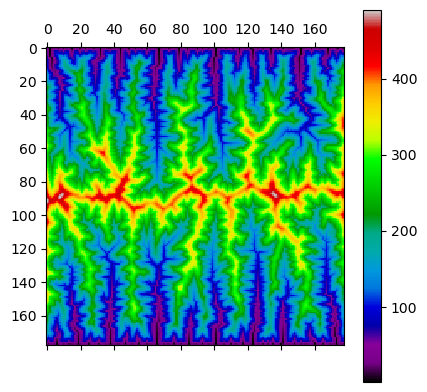

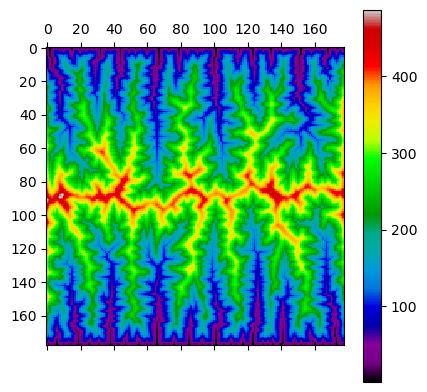

In [193]:
future_index = 0
ground_index = testing_idx-1
print(testing_idx)

plt.matshow(sparse_future_reconstruction['Sparse_Future_SST'][future_index], cmap='nipy_spectral')
plt.colorbar()

plt.matshow(data[ground_index], cmap='nipy_spectral')
plt.colorbar()

print(f"MSE of reconstruction: {np.mean((sparse_future_reconstruction['Sparse_Future_SST'][future_index] - data[ground_index])**2)}")

Now below, if we use the dense sensor measurements, we will find that forecasting is much more accurate and generates a forecast of the evolution of the elevation and fluvial diffusion much better than the sparse sensor measurements. In conclusion, more well-placed sensors allows SHRED to learn POD modes/functions, as well as train latent layers within the model, that are far more representative of the true evolution of the data.

MSE of reconstruction: 129.51438715188402


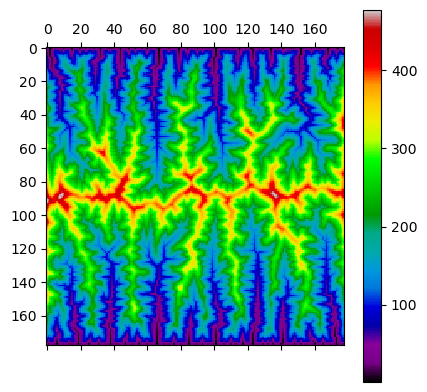

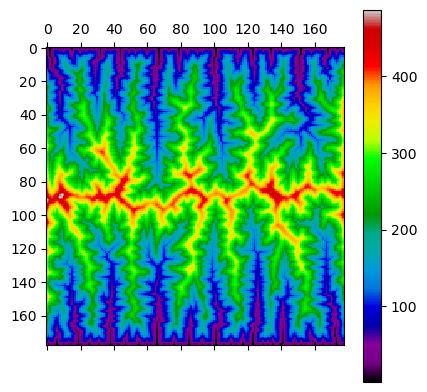

In [ ]:
future_index = 0
ground_index = testing_idx-1

# Go to the full state RIGHT before prediction/forecasting, to compare results (since they will be very similar)
# For ACCURATE MSE readings, make sure to not wipe the full state data after testing_idx and compare the forecast
# against that state instead. Otherwise the MSE is invalid.

plt.matshow(dense_future_reconstruction['Dense_Future_SST'][future_index], cmap='nipy_spectral')
plt.colorbar()

plt.matshow(data[ground_index], cmap='nipy_spectral')
plt.colorbar()

print(f"MSE of reconstruction: {np.mean((dense_future_reconstruction['Dense_Future_SST'][future_index] - data[ground_index])**2)}")

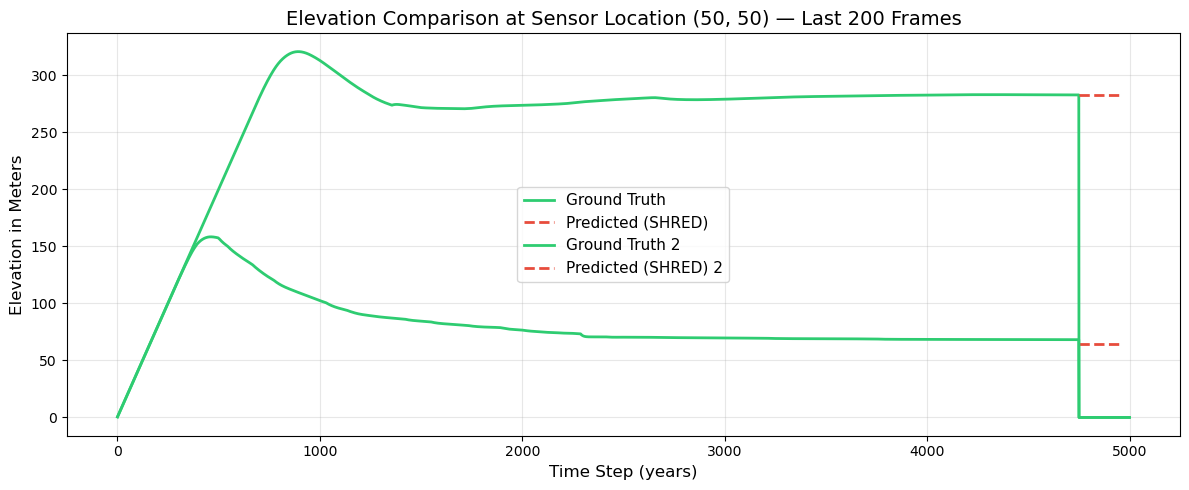

In [187]:
# Compare predicted vs ground truth ELEVATION at a single sensor location over last 100 frames
num_frames = 200
sensor_location = dense_locations[3]  # Using first sensor at (75, 165)
row, col = sensor_location

# Get the reconstruction data
predicted_data = dense_future_reconstruction['Dense_Future_SST']

# Calculate where the reconstruction aligns with ground truth
ground_truth_start_idx = len(data) - predicted_data.shape[0]

# Extract the last num_frames frames from both datasets
predicted_sst = predicted_data[-num_frames:, row, col]
ground_truth_sst = data[:, row, col]

# Create the comparison plot
fig, ax = plt.subplots(figsize=(12, 5))

time_steps = np.arange(len(ground_truth_sst))
prediction_time_steps = np.arange(num_frames) + testing_idx

ax.plot(time_steps, ground_truth_sst, label='Ground Truth', color='#2ecc71', linewidth=2)
ax.plot(prediction_time_steps, predicted_sst, label='Predicted (SHRED)', color='#e74c3c', linewidth=2, linestyle='--')

# Let's check another location as well
sensor_location = dense_locations[5]
row, col = sensor_location

predicted_sst = predicted_data[-num_frames:, row, col]
ground_truth_sst = data[:, row, col]

ax.plot(time_steps, ground_truth_sst, label='Ground Truth 2', color='#2ecc71', linewidth=2)
ax.plot(prediction_time_steps, predicted_sst, label='Predicted (SHRED) 2', color='#e74c3c', linewidth=2, linestyle='--')

ax.set_xlabel('Time Step (years)', fontsize=12)
ax.set_ylabel('Elevation in Meters', fontsize=12)
ax.set_title(f'Elevation Comparison at Sensor Location {sensor_location} — Last {num_frames} Frames', fontsize=14)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

What's to notice here is how SHRED's forecast can continue to forecast granular datapoints that nearly match the trajectory of that datapoint's evolution from before the point where full state data starts being incomplete.